## Confirming bpnet-lite loads models from the official repos correctly
Author: Jacob Schreiber

An important feature in bpnet-lite is being able to load models trained using the official TensorFlow repos into PyTorch and get exactly the same predictions. In this notebook, we will demonstrate this using models trained using the official BPNet and ChromBPNet repositories and uploaded to the ENCODE Portal. Not all of these models have been publicly released yet, but this will be the process for loading and using them once they are available. Fortunately for us, these uploads also come with predictions from these models made by those who trained the models which we can compare against to make sure we get the same thing.


### ChromBPNet

Let's start with ChromBPNet because it is conceptually the easiest to verify (for reasons we will see later). We can load the ChromBPNet model directly from the h5, as demonstrated in the tutorial on loading, saving, and converting models. Because a ChromBPNet model is made up of an accessibility model and a bias model, we pull each one out and then pass them into the `ChromBPNet` wrapper.

In [1]:
import tarfile

from io import BytesIO
from bpnetlite.chrombpnet import ChromBPNet

with tarfile.open("ENCFF142IOR.tar.gz", "r:gz") as tar:
    bias_tar = tar.extractfile("./fold_0/model.bias_scaled.fold_0.ENCSR637XSC.h5").read()
    accessibility_tar = tar.extractfile("./fold_0/model.chrombpnet_nobias.fold_0.ENCSR637XSC.h5").read()

chrombpnet = ChromBPNet.from_chrombpnet(
    BytesIO(bias_tar),
    BytesIO(accessibility_tar)
)

chrombpnet

ChromBPNet(
  (bias): BPNet(
    (iconv): Conv1d(4, 128, kernel_size=(21,), stride=(1,), padding=(10,))
    (irelu): ReLU()
    (rconvs): ModuleList(
      (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
      (1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
      (2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
      (3): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
    )
    (rrelus): ModuleList(
      (0-3): 4 x ReLU()
    )
    (fconv): Conv1d(128, 1, kernel_size=(75,), stride=(1,), padding=(37,))
    (linear): Linear(in_features=128, out_features=1, bias=True)
  )
  (accessibility): BPNet(
    (iconv): Conv1d(4, 512, kernel_size=(21,), stride=(1,), padding=(10,))
    (irelu): ReLU()
    (rconvs): ModuleList(
      (0): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
      (1): Conv1d(512, 512, kernel_size=(3,), stride=(1

Because we want to verify that the predictions are the same, we need to choose regions that are identical and centered in the same manner as the predictions that have been uploaded to the portal. Fortunately, a BED file of these regions has been provided alongside the uploaded predictions so we can just use a tangermeme function to load genome sequence from a subset of those regions.

In [2]:
from tangermeme.io import extract_loci

n_loci = 1000
X = extract_loci("test/fold_0/peaks.bed", "../../../../common/hg38.fa", verbose=True, n_loci=n_loci)

Loading Loci:   0%|▏                                                            | 999/423350 [00:00<00:05, 74720.65it/s]


And we can make predictions for these regions using the model that has been loaded using bpnet-lite.

In [3]:
from tangermeme.predict import predict

y_hat_logits, y_hat_logcounts = predict(chrombpnet, X)

Now, we can load up the official predictions for these regions that have been provided by the authors of the original model. Because Chrom/BPNet models make predictions for both the log counts and the profile (in the form of unnormalized logits) of a region, we will want to ensure that both are identical. As a note, these predictions were made entirely within their TensorFlow framework by them.

In [4]:
import h5py

official_preds = h5py.File("test/fold_0/pred.chrombpnet.fold_0.ENCSR637XSC.h5", "r")

y_logits = official_preds['predictions']['logits'][:n_loci]
y_logcounts = official_preds['predictions']['logcounts'][:n_loci]

As an initial check, we can look at the profile predictions for a single region (after softmaxing, because that is how most people look at these profile predictions) and visually check that they look pretty similar to each other.

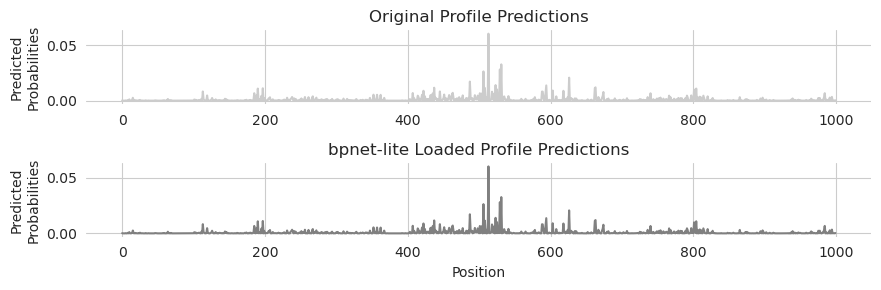

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn; seaborn.set_style('whitegrid')
from scipy.special import softmax

plt.figure(figsize=(9, 3))
plt.subplot(211)
plt.title("Original Profile Predictions")
plt.plot(softmax(y_logits[0]), c='0.8')
plt.ylabel("Predicted\nProbabilities")
seaborn.despine(bottom=True, left=True)

plt.subplot(212)
plt.title("bpnet-lite Loaded Profile Predictions")
plt.plot(softmax(y_logits[0]), c='0.5')
plt.ylabel("Predicted\nProbabilities")
plt.xlabel("Position")
seaborn.despine(bottom=True, left=True)

plt.tight_layout()
plt.show()

They look pretty similar!

Now, we can do something more quantitative. We can plot a scatterplot of all of the log count and logit predictions across all of the loaded regions. We want to see a line on x=y, which would indicate that the predictions made from the model within this PyTorch framework (being loaded into PyTorch using bpnet-lite and then making predictions using tangermeme) are identical to predictions originally made in the entirely-TensorFlow framework.

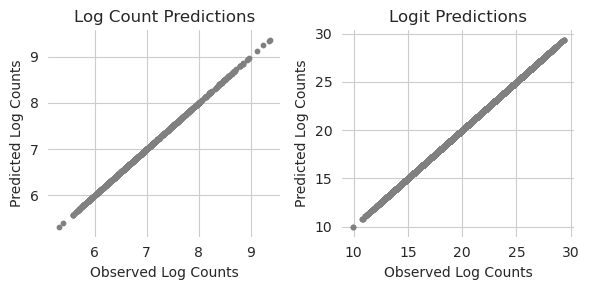

In [6]:
plt.figure(figsize=(6, 3))
plt.subplot(121)
plt.title("Log Count Predictions")
plt.scatter(y_logcounts[:, 0], y_hat_logcounts[:, 0], s=10, c='0.5')
plt.xlabel("Observed Log Counts")
plt.ylabel("Predicted Log Counts")
seaborn.despine(bottom=True, left=True)

plt.subplot(122)
plt.title("Logit Predictions")
plt.scatter(y_logits.flatten(), y_hat_logits.flatten(), s=10, c='0.5')
plt.xlabel("Observed Log Counts")
plt.ylabel("Predicted Log Counts")
seaborn.despine(bottom=True, left=True)

plt.tight_layout()
plt.show()

As further numeric proof, we can calculate the maximum difference in any predicted value for each of the two types of predictions. Note that we would expect small accumulation errors on the GPU to add up to something slightly above numeric precision because we are using a different GPU than the original authors.

In [7]:
import numpy

print("Maximum Log Count Difference", numpy.abs(y_logcounts - y_hat_logcounts.numpy()).max())
print("Maximum Logits Difference", numpy.abs(y_logits - y_hat_logits[:, 0].numpy()).max())

Maximum Log Count Difference 0.0013670921325683594
Maximum Logits Difference 0.003086090087890625


Looks like these values are quite small! And remember, this is the *maximum* difference across *any* predicted value. Most are quite a bit smaller than that.

In [8]:
print("Mean Log Count Difference", numpy.abs(y_logcounts - y_hat_logcounts.numpy()).mean())
print("Mean Logits Difference", numpy.abs(y_logits - y_hat_logits[:, 0].numpy()).mean())

Mean Log Count Difference 0.00020241308212280273
Mean Logits Difference 0.00033962452125549315


#### Accessibility Model

Having confirmed that the full ChromBPNet model yields identical predictions, we can now check that the accessibility model also has matched predictions. Note that this is not quite as simple as taking the uploaded bigWigs for the de-biased accessibility and loading the values at the same peaks that we considered before, because those predictions may not have been made centered at the same loci. For complete reproducibility, we need to load up the h5 of predictions from the accessibility model alone and make sure we are matching the exact sequences.

In [9]:
import pandas

with tarfile.open("ENCFF840BOR.tar.gz", "r:gz") as tar:
    pred_tar = tar.extractfile("./fold_0/pred.chrombpnet_nobias.fold_0.ENCSR637XSC.h5").read()

official_chrombpnet_predictions = h5py.File(
    BytesIO(pred_tar)
)

coords = pandas.DataFrame({
    'chrom': official_chrombpnet_predictions['coords/coords_chrom'][:].astype(str),
    'start': official_chrombpnet_predictions['coords/coords_start_dset'][:],
    'end': official_chrombpnet_predictions['coords/coords_end_dset'][:]
})

y_acc_logits = official_chrombpnet_predictions['predictions']['logits'][:n_loci]
y_acc_logcounts = official_chrombpnet_predictions['predictions']['logcounts'][:n_loci]

Given the loci are provided, we can use the same function to load up the sequences at those loci.

In [10]:
X = extract_loci(coords, "../../../../common/hg38.fa", verbose=True, n_loci=n_loci)

y_hat_acc_profile, y_hat_acc_logcounts = predict(chrombpnet.accessibility, X)

Loading Loci:   0%|▏                                                            | 999/423350 [00:00<00:05, 74826.06it/s]


Let's visualize one of the predictions (because the accessibility model is cool).

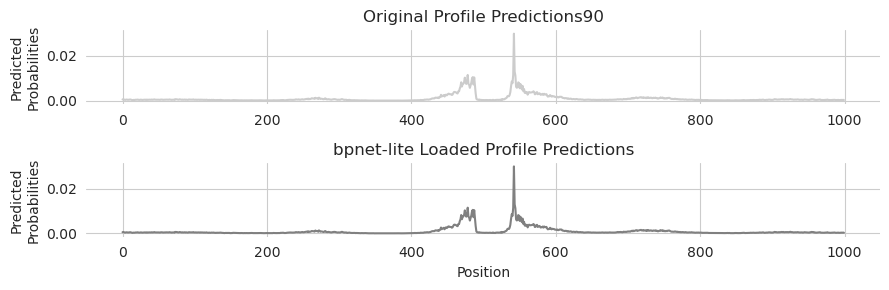

In [11]:
idx = 90

plt.figure(figsize=(9, 3))
plt.subplot(211)
plt.title("Original Profile Predictions" + str(idx))
plt.plot(softmax(y_acc_logits[idx]), c='0.8')
plt.ylabel("Predicted\nProbabilities")
seaborn.despine(bottom=True, left=True)

plt.subplot(212)
plt.title("bpnet-lite Loaded Profile Predictions")
plt.plot(softmax(y_hat_acc_profile[idx, 0]), c='0.5')
plt.ylabel("Predicted\nProbabilities")
plt.xlabel("Position")
seaborn.despine(bottom=True, left=True)

plt.tight_layout()
plt.show()

We can then check more quantiatively that the predictions for both the log counts and logits are the same.

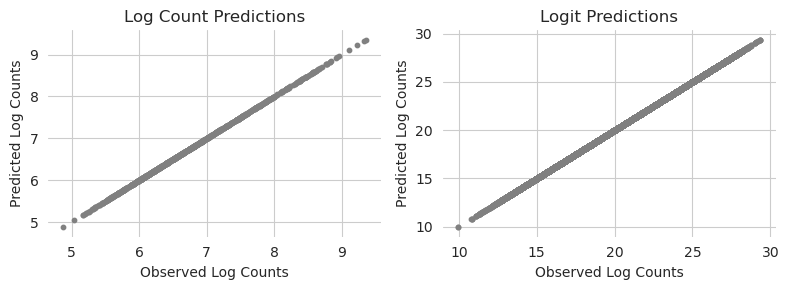

In [12]:
plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.title("Log Count Predictions")
plt.scatter(y_acc_logcounts[:, 0], y_hat_acc_logcounts[:, 0], s=10, c='0.5')
plt.xlabel("Observed Log Counts")
plt.ylabel("Predicted Log Counts")
seaborn.despine(bottom=True, left=True)

plt.subplot(122)
plt.title("Logit Predictions")
plt.scatter(y_logits.flatten(), y_hat_logits.flatten(), s=10, c='0.5')
plt.xlabel("Observed Log Counts")
plt.ylabel("Predicted Log Counts")
seaborn.despine(bottom=True, left=True)

plt.tight_layout()
plt.show()

Looks like the models loaded into bpnet-lite produce identical predictions for the full ChromBPNet model as well as the accessibility model! Unfortunately, predictions are not provided for the bias model so we cannot directly compare our predictions in that setting, but hopefully this is enough proof for now!

### BPNet

Although BPNet models are simpler conceptually (after all, a ChromBPNet model is *two* BPNet models), reproducing the predictions uploaded to the ENCODE Portal is a bit more challenging. This is because the predictions uploaded to the portal are not the raw outputs from the model, like they were for ChromBPNet, but, rather, have been processed significantly. The tl;dr is that when we match the exact processing that was performed we can see that one can use bpnet-lite to reproduce these results exactly, but we have to make sure to actually match the processing.

First, we can load up the model in roughly the same way as the ChromBPNet model.

<b>MAKE SURE YOU USE `BasePairNet` AND NOT `BPNet` WHEN LOADING MODELS FROM THE OFFICIAL REPO.</b> This is because there is a small difference in the internal operations between BPNet models in the official repository and the BPNet models used as units in the ChromBPNet model. Specifically, in BasePairNet, the activations happen after the residual addition rather than directly after the convolution. It is unclear whether this affects performance but does have the advantage of not forcing internal representations to always grow by having the residual connections only adding non-negative values.

In [13]:
from bpnetlite.bpnet import BasePairNet

with tarfile.open("ctcf-bpnet/ENCFF500SSJ.tar.gz", "r:gz") as tar:
    model = tar.extractfile("./fold_0/model.fold_0.ENCSR000DRR.h5").read()

bpnet = BasePairNet.from_bpnet(
    BytesIO(model)
)

bpnet

BasePairNet(
  (iconv): Conv1d(4, 64, kernel_size=(21,), stride=(1,), padding=(10,))
  (irelu): ReLU()
  (rconvs): ModuleList(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
    (1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
    (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
    (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
    (4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
    (5): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
    (6): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
    (7): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(256,), dilation=(256,))
  )
  (rrelus): ModuleList(
    (0-7): 8 x ReLU()
  )
  (fconv): Conv1d(66, 2, kernel_size=(75,), stride=(1,), padding=(37,))
  (linear): Linear(in_features=65, out_features=1, bias=True)

Now we can load up the coordinates from the uploaded h5 to make sure we are making predictions on exactly the same sequences.

In [14]:
with tarfile.open("ctcf-bpnet/ENCFF682VEE.tar.gz", "r:gz") as tar:
    bpnet_pred_tar = tar.extractfile("./fold_0/pred.plus_minus_strand.fold_0.ENCSR000DRR.h5").read()

official_bpnet_predictions = h5py.File(
    BytesIO(bpnet_pred_tar)
)

coords = pandas.DataFrame({
    'chrom': official_bpnet_predictions['coords/coords_chrom'][:].astype(str),
    'start': official_bpnet_predictions['coords/coords_start'][:],
    'end': official_bpnet_predictions['coords/coords_end'][:]
})

coords

,chrom,start,end
0,chr1,267506,268506
1,chr1,585699,586699
2,chr1,778400,779400
3,chr1,869423,870423
4,chr1,904273,905273
...,...,...,...
40545,chrY,20576129,20577129
40546,chrY,20648598,20649598
40547,chrY,20740341,20741341
40548,chrY,20744660,20745660


Then, we can load up the official profile and logcount predictions. Unfortunately, neither one of these are the direct output from a trained model as is suggested by being called profs and not logits. 

In [15]:
y_logits = official_bpnet_predictions['predictions/pred_profs'][:]
y_logcounts = official_bpnet_predictions['predictions/pred_logcounts'][:]

Next, we can make predictions on the extracted coordinates using the loaded model. Remember to use the control tracks to match the predictions exactly! Otherwise, making the predictions is straightforward, and the results are the predicted logits (stranded) and log counts (total across both strands).

In [16]:
controls = ["ctcf-bpnet/ENCSR000DRR_control_plus.bigWig", "ctcf-bpnet/ENCSR000DRR_control_minus.bigWig"]

X, X_ctl = extract_loci(coords, "/home/jmschrei/common/hg38.fa", controls, out_window=2114, verbose=True)

y_hat_logits, y_hat_logcounts = predict(bpnet, X, args=(X_ctl,), verbose=True)
y_hat_logits.shape, y_hat_logcounts.shape

100%|██████████████████████████████████████████████████████████████████████████████| 1268/1268 [00:05<00:00, 239.92it/s]


(torch.Size([40550, 2, 1000]), torch.Size([40550, 1]))

Let's start off by comparing the logits predicted by the model to the loaded profiles.

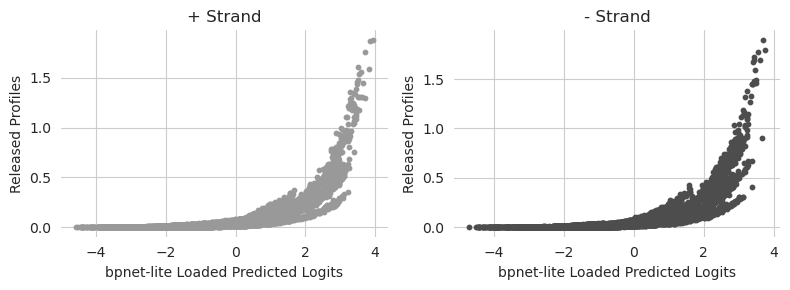

In [17]:
plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.title("+ Strand")
plt.scatter(y_hat_logits[:10, 0].flatten(), y_logits[:10, :, 0], s=10, c='0.6')
plt.xlabel("bpnet-lite Loaded Predicted Logits")
plt.ylabel("Released Profiles")
seaborn.despine(bottom=True, left=True)

plt.subplot(122)
plt.title("- Strand")
plt.scatter(y_hat_logits[:10, 1].flatten(), y_logits[:10, :, 1], s=10, c='0.3')
plt.xlabel("bpnet-lite Loaded Predicted Logits")
plt.ylabel("Released Profiles")
seaborn.despine(bottom=True, left=True)

plt.tight_layout()
plt.show()

Looks like there are major differences. The predicted logits are both negative and positive, whereas the released profiles seem to have a minimum of zero but also exceed 1, so clearly aren't either probabilities or logits.

The tl;dr is that these profiles are reverse-complement averaged, softmaxed, and then multiplied by the exponentiated counts. It is done this way to most closely match with the experimental data with the values at each position being an expectation of the number of reads mapping to each position.

To get there, we should first reverse complement the predictions. Remember to reverse complement the sequence, the control tracks, and then finally the profile predictions themselves!

In [18]:
import torch

y_hat_logits_rc, y_hat_logcounts_rc = predict(bpnet, torch.flip(X, dims=(-1, -2)), args=(torch.flip(X_ctl, dims=(-1, -2)),))
y_hat_logits_rc = torch.flip(y_hat_logits_rc, dims=(-1, -2))

y_hat_logits_avg = (y_hat_logits + y_hat_logits_rc) / 2
y_hat_logcounts_avg = (y_hat_logcounts + y_hat_logcounts_rc) / 2

After averaging, we then softmax across both strands (so the sum of predictions across both strands is equal to 1) and then multiply by the exponentiated counts. A numerically stable version of this proceeds by taking the log softmax, adding the logcounts, and then only exponentiating at the end. This gives us our profile predictions.

In [19]:
n = y_hat_logits.shape[0]
z = y_hat_logits.shape

y_hat_profiles = torch.nn.functional.log_softmax(y_hat_logits_avg.reshape(n, -1), dim=-1).reshape(*z)
y_hat_profiles = torch.exp(y_hat_profiles + y_hat_logcounts_avg[:, None])

Let's take a look at one to make sure it's the same.

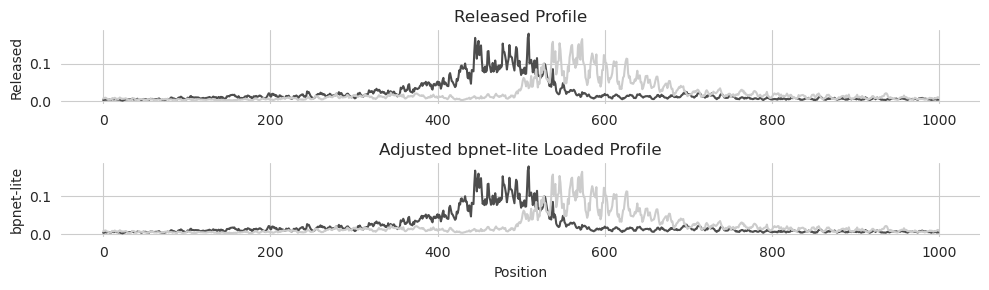

In [20]:
idx = 5

plt.figure(figsize=(10, 3))
plt.subplot(211)
plt.title("Released Profile")
plt.plot(y_logits[idx, :, 0], c='0.3')
plt.plot(y_logits[idx, :, 1], c='0.8')
seaborn.despine(bottom=True, left=True)
plt.ylabel("Released")

plt.subplot(212)
plt.title("Adjusted bpnet-lite Loaded Profile")
plt.plot(y_hat_profiles[idx, 0], c='0.3')
plt.plot(y_hat_profiles[idx, 1], c='0.8')
seaborn.despine(bottom=True, left=True)
plt.xlabel("Position")
plt.ylabel("bpnet-lite")

plt.tight_layout()
plt.show()

Great. So how do we get the released log counts? This is easy after calculating the profiles -- all we need to do is sum the expected reads for each strand and then take the log (adding 1 to each strand). 

In [21]:
y_hat_logcounts_strand = torch.log(torch.sum(y_hat_profiles, dim=-1))

We can more comprehensively take a look at those now.

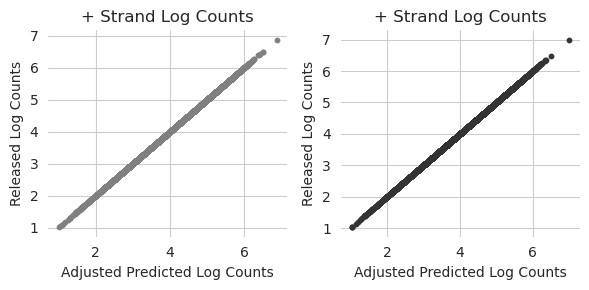

In [22]:
plt.figure(figsize=(6, 3))
plt.subplot(121)
plt.scatter(y_hat_logcounts_strand[:, 0].numpy(), y_logcounts[:, 0], s=10, c='0.5')
seaborn.despine(bottom=True, left=True)
plt.title("+ Strand Log Counts")
plt.xlabel("Adjusted Predicted Log Counts")
plt.ylabel("Released Log Counts")

plt.subplot(122)
plt.title("+ Strand Log Counts")
plt.scatter(y_hat_logcounts_strand[:, 1].numpy(), y_logcounts[:, 1], s=10, c='0.2')
seaborn.despine(bottom=True, left=True)
plt.xlabel("Adjusted Predicted Log Counts")
plt.ylabel("Released Log Counts")

plt.tight_layout()
plt.show()

We can then return to make the same type of plot for the profile predictions.

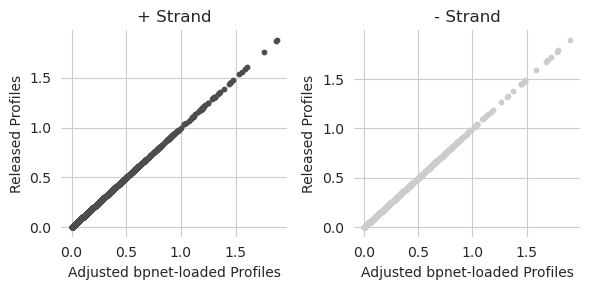

In [23]:
plt.figure(figsize=(6, 3))
plt.subplot(121)
plt.title("+ Strand")
plt.scatter(y_hat_profiles[:10, 0], y_logits[:10, :, 0], c='0.3', s=10)
seaborn.despine(bottom=True, left=True)
plt.xlabel("Adjusted bpnet-loaded Profiles")
plt.ylabel("Released Profiles")


plt.subplot(122)
plt.title("- Strand")
plt.scatter(y_hat_profiles[:10, 1], y_logits[:10, :, 1], c='0.8', s=10)
seaborn.despine(bottom=True, left=True)
plt.xlabel("Adjusted bpnet-loaded Profiles")
plt.ylabel("Released Profiles")

plt.tight_layout()
plt.show()

Finally, we can report the maximum difference for the log counts and the profile predictions.

In [24]:
print("Maximum Log Count Difference", numpy.abs(y_logcounts - y_hat_logcounts_strand.numpy()).max())
print("Maximum Logits Difference", numpy.abs(y_logits - y_hat_profiles.transpose(1, 2).numpy()).max())

Maximum Log Count Difference 0.0015931129455566406
Maximum Logits Difference 0.013546943664550781


### Wrap-Up

This notebook shows that the models trained using the official TensorFlow repositories can be loaded into PyTorch using bpnet-lite and produce identical predictions. The only caveats here are that you need to use `BasePairNet` instead of `BPNet` due to a small difference in the internal operations of the residual block, and that *when validating that this is true for BPNet*, you need to process the predictions in a specific way. This does not mean you always need to process the predictions from the model in this manner, but just that you need to do to it this way to reproduce the predictions uploaded to the ENCODE Portal.